In [62]:
# Basic installs (most are already in Colab, but this is safe)
!pip install xgboost --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [63]:
import pandas as pd

# Replace with the exact file name you uploaded
file_path = "/content/Daily Demand Forecasting Orders.csv"
df = pd.read_csv(file_path)

df.head()


,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [64]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          60 non-null     int64  
 1   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 2   Day of the week (Monday to Friday)                                  60 non-null     int64  
 3   Non-urgent order                                                    60 non-null     float64
 4   Urgent order                                                        60 non-null     float64
 5   Order type A                                                        60 non-null     float64
 6   Order type B                                                        60 non-null     float64
 7   Order type C       

,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [65]:
df.isna().sum()

,0
Unnamed: 0,0
"Week of the month (first week, second, third, fourth or fifth week",0
Day of the week (Monday to Friday),0
Non-urgent order,0
Urgent order,0
Order type A,0
Order type B,0
Order type C,0
Fiscal sector orders,0
Orders from the traffic controller sector,0


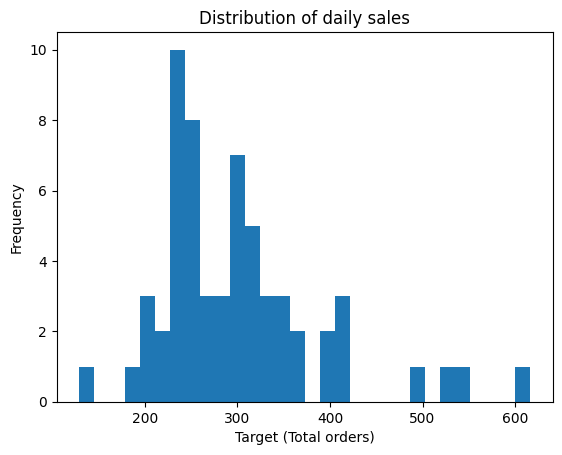

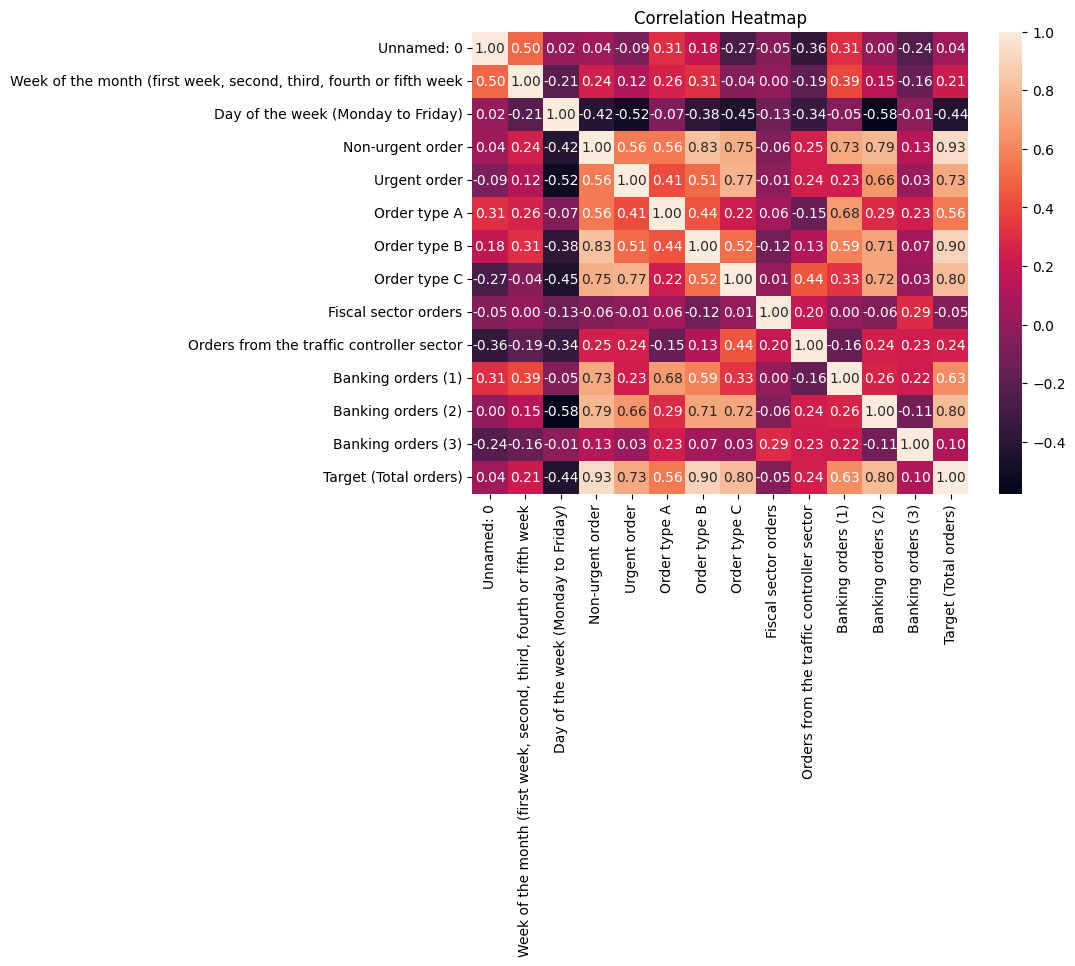

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of target (e.g., 'Sales per day')
target_col = 'Target (Total orders)'  # change if your column name is different
plt.hist(df[target_col], bins=30)
plt.xlabel(target_col)
plt.ylabel("Frequency")
plt.title("Distribution of daily sales")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Histogram- graphical representation of the distribution a single numerical integer
Heatmap- Visual representation of values in a matrix, where colors represent the magnitude

In [67]:
# If no explicit date column, ensure sorted by index
df = df.sort_index()

# Create lag features for target... This lag features help you find the pattern
df['lag_1'] = df[target_col].shift(1)
df['lag_7'] = df[target_col].shift(7)

# Rolling mean of last 7 days helps you check whether these patterns are correct without getting tricked by one day spikes
df['rolling_mean_7'] = df[target_col].shift(1).rolling(window=7).mean()

# Drop initial NA rows caused by shifting
df = df.dropna().reset_index(drop=True)

df.head()


,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders),lag_1,lag_7,rolling_mean_7
0,7,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502,248.958,263.043,539.577,270.244000
1,8,3,2,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458,344.291,248.958,224.675,228.727000
2,9,3,3,146.518,101.045,36.399,43.306,168.723,865.000,58224,7742,82395,11948,248.428,344.291,129.412,245.815000
3,10,3,4,178.433,102.793,45.706,111.036,124.678,194.000,47046,17299,108719,15560,281.420,248.428,317.120,262.817286
4,11,3,5,145.865,91.180,43.851,66.277,133.440,6.523,66910,17768,36693,29046,243.568,281.420,210.517,257.717286


In [68]:
# Define features and target
feature_cols = [col for col in df.columns if col != target_col]
X = df[feature_cols].values
y = df[target_col].values

split_index = int(len(df) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape


((42, 16), (11, 16))

Why did we choose Random Forests?
It is strong for tabular and Time series Features.It works well with the Lag features,Rolling Averages,Claender features and Derived features

In [69]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1#Speeds up training by parallelizig across CPU cores
)
rf.fit(X_train, y_train)# It creates the baseline model that ccaptures the non-linear relationships in your engieered features

y_pred_rf = rf.predict(X_test)#Testing the data. Each tree generates a prediction and random forest averages all the predictions. predict() averages outputs from all trees to generate robust,low-variance predictions.

def evaluate(y_true, y_pred, model_name="model"):
    mse = mean_squared_error(y_true, y_pred)#Penalises the large errors heavily
    rmse = np.sqrt(mse)# It gives how much o an average is the predicted no of orders away from the true no of orders(It removes the large errored orders). It gives how bad the predictions are when we consider big errors
    mae = mean_absolute_error(y_true, y_pred)#It gives how much o an average is the predicted no of orders away from the true no of orders.
    r2 = r2_score(y_true, y_pred)#Measures how well the model explains the variance
    print(f"{model_name} - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

evaluate(y_test, y_pred_rf, "Random Forest")
#More trees- reduces variance and improve prediction


Random Forest - RMSE: 29.748, MAE: 25.295, R2: 0.657


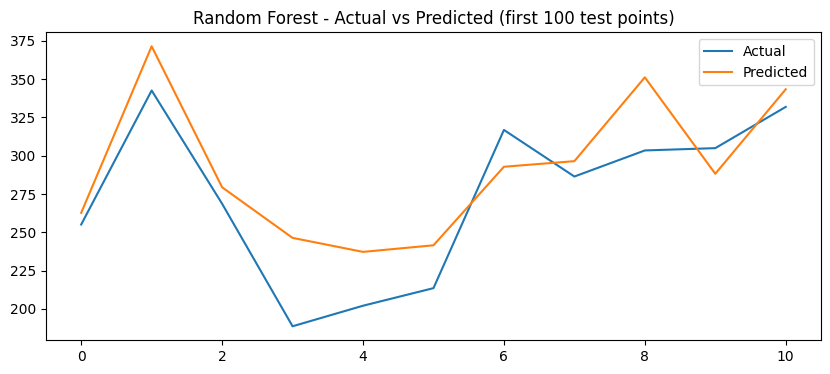

In [70]:
plt.figure(figsize=(10,4))
plt.plot(y_test[:100], label="Actual")
plt.plot(y_pred_rf[:100], label="Predicted")
plt.legend()
plt.title("Random Forest - Actual vs Predicted (first 100 test points)")
plt.show()


LSTM Deep Learning Model for Time Series
Why LSTM?
Time series data has sequencial dependence:what happens today depends on a sequence of previous days. It is designed to capture such sequenctial patterns and long term dependencies

In [71]:
from sklearn.preprocessing import StandardScaler
import numpy as np

seq_len = 14  # number of days in each input sequence

# 1) Scale X (features)
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(df[feature_cols])

# 2) Scale y (target)
y_full = df[target_col].values.reshape(-1, 1)  # make it 2D for scaler
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_full)      # still 2D
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])  # last seq_len rows as one sequence
        y_seq.append(y[i])           # target is value at time i
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)
print(X_seq.shape, y_seq.shape)


(39, 14, 16) (39, 1)


Now split time-wise:

In [72]:
split_index = int(len(X_seq) * 0.8)

X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

print(X_train_seq.shape, X_test_seq.shape)


(31, 14, 16) (8, 14, 16)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(32, input_shape=(seq_len, X_train_seq.shape[2])),
    Dense(16, activation='relu'),
    Dense(1)  # regression output (scaled y)
])

model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,              # more training than before
    batch_size=32,
    validation_split=0.1,   # 10% of train used for validation
    callbacks=[es],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.3586 - val_loss: 0.8393
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 1.3291 - val_loss: 0.8470
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 1.3002 - val_loss: 0.8555
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 1.2774 - val_loss: 0.8640
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.2570 - val_loss: 0.8723
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 1.2387 - val_loss: 0.8799


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
LSTM - RMSE: 57.326, MAE: 44.145, R2: -0.140


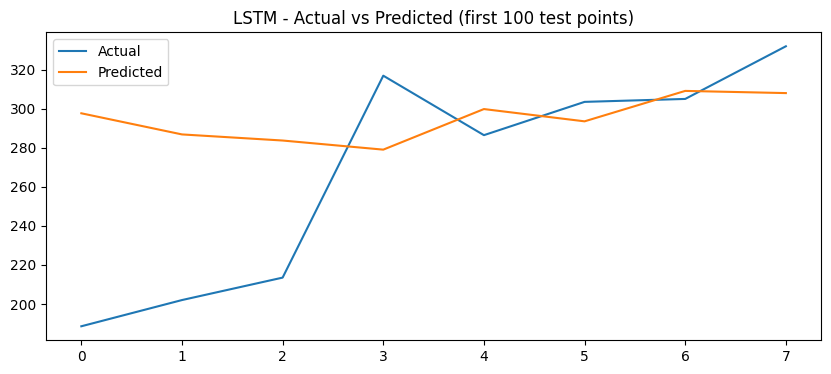

In [74]:
# Predict on test sequences (scaled)
y_pred_scaled = model.predict(X_test_seq)

# Flatten shapes
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_test_scaled = y_test_seq.reshape(-1, 1)

# Inverse transform back to original units (orders)
y_pred_lstm = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_lstm = y_scaler.inverse_transform(y_test_scaled).flatten()

# Reuse your evaluate() function from before
evaluate(y_test_lstm, y_pred_lstm, "LSTM")

# Plot first 100 points
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_test_lstm[:100], label="Actual")
plt.plot(y_pred_lstm[:100], label="Predicted")
plt.legend()
plt.title("LSTM - Actual vs Predicted (first 100 test points)")
plt.show()


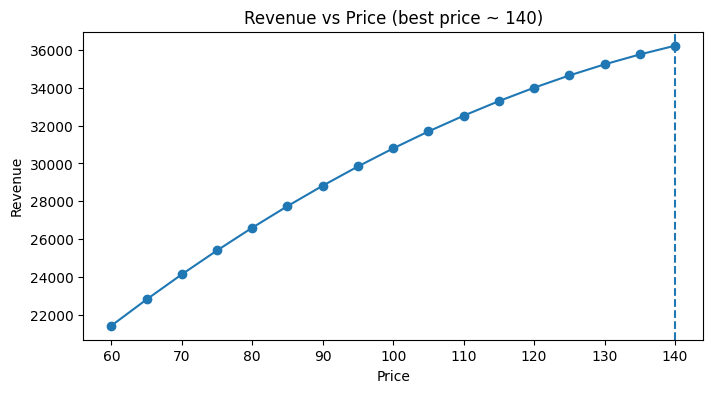

Base predicted demand: 307.94
Optimal price (simulated): 140, Expected revenue: 36213.97


In [75]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# FUNCTION: simulate_revenue
# --------------------------------------------------------------
# PURPOSE:
#   Given a baseline predicted demand (d_base), this function simulates
#   how demand changes with different prices using a simple price elasticity model.
#   Then it calculates revenue at each price and returns the best price.
#
# WHY WE DO THIS:
#   - In real life, demand decreases when price increases (price elasticity).
#   - We do not have actual price data, so we simulate a realistic relationship.
#   - This lets us build a simple dynamic pricing engine using our demand forecast.
# --------------------------------------------------------------

def simulate_revenue(d_base, p_base=100, elasticity=0.4, price_range=(60, 140), step=5):

    # Create a list of prices to test, e.g., [60, 65, 70, ..., 140]
    prices = np.arange(price_range[0], price_range[1] + 1, step)

    demands = []   # stores simulated demand for each price
    revenues = []  # stores revenue for each price

    # Loop through every possible price
    for p in prices:

        # ----------------------------------------------------------
        # PRICE–DEMAND FORMULA (ECONOMICS)
        #
        # d(p) = d_base * (1 - elasticity * (p - p_base) / p_base)
        #
        # Meaning:
        #   - If price increases above p_base, demand decreases.
        #   - If price decreases below p_base, demand increases.
        #   - elasticity controls how sensitive demand is to price.
        # ----------------------------------------------------------

        demand_p = d_base * (1 - elasticity * (p - p_base) / p_base)

        # Prevent negative demand (makes no sense in real world)
        demand_p = max(demand_p, 0)

        # Store simulated demand
        demands.append(demand_p)

        # Revenue = price * demand
        revenues.append(p * demand_p)

    # Find index where revenue is maximum
    best_idx = np.argmax(revenues)

    return prices, demands, revenues, best_idx


# --------------------------------------------------------------
# EXAMPLE USE:
# --------------------------------------------------------------
# We take the last predicted demand from LSTM as baseline demand.
# Example: the model predicted 336.71 for the last day → use it.
# --------------------------------------------------------------

example_idx = -1  # last test sample
d_base = y_pred_lstm[example_idx]  # baseline predicted demand


# Run the simulation
prices, demands, revenues, best_idx = simulate_revenue(d_base)


# --------------------------------------------------------------
# VISUALIZATION:
# --------------------------------------------------------------
# Plot revenue vs price, and highlight which price gives max revenue.
# --------------------------------------------------------------

plt.figure(figsize=(8,4))
plt.plot(prices, revenues, marker='o')              # Revenue curve
plt.axvline(prices[best_idx], linestyle='--')       # Best price line
plt.title(f"Revenue vs Price (best price ~ {prices[best_idx]})")
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.show()


# --------------------------------------------------------------
# PRINT RESULTS:
# --------------------------------------------------------------
print(f"Base predicted demand: {d_base:.2f}")
print(f"Optimal price (simulated): {prices[best_idx]}, Expected revenue: {revenues[best_idx]:.2f}")


In [82]:
!find / -maxdepth 4 -name "*.ipynb" 2>/dev/null
